In [739]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [740]:
# pip install pyarrow
# pip install fastparquet

In [741]:
# https://figshare.com/articles/dataset/A_public_dataset_on_long-distance_running_training_in_2019_and_2020/16620238
data = pd.read_parquet('run_ww_2019_d.parquet')

## Data observations

In [742]:
data.head()
## some lines contain zeroes - the db contains each day of the year for every athlete, regardles of the
## actual training 

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2019-01-01,0,0.00,0.00,F,18 - 34,United States,CHICAGO 2019
1,2019-01-01,1,5.27,30.20,M,35 - 54,Germany,BERLIN 2016
2,2019-01-01,2,0.00,0.00,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2019-01-01,3,10.50,43.95,M,18 - 34,United Kingdom,LONDON 2017
4,2019-01-01,4,9.66,48.65,M,35 - 54,United States,BOSTON 2017


In [743]:
data.shape
print('We have {} entries in our training dataset.'.format(data.shape[0]))
print('For {} athletes.'.format(data['athlete'].nunique()))

We have 13290380 entries in our training dataset.
For 36412 athletes.


In [744]:
data = data[(data['distance']>0)&(data['duration']>0)]
print('Down to {} trainings after we exclude non-training days'.format(data.shape[0]))

Down to 4677389 trainings after we exclude non-training days


In [745]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677389 entries, 1 to 13290379
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   athlete    int64         
 2   distance   float64       
 3   duration   float64       
 4   gender     object        
 5   age_group  object        
 6   country    object        
 7   major      object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 321.2+ MB


In [746]:
data['major'].value_counts()
## some majors relate to previous years, some are aggregated

BOSTON 2019                            611295
BERLIN 2019                            478580
BOSTON 2018                            280279
BERLIN 2018                            265114
NEW YORK 2019                          259502
                                        ...  
BERLIN 2014,TOKYO 2015                      2
BERLIN 2016,BOSTON 2014,BOSTON 2016         2
BOSTON 2016,NEW YORK 2013                   1
TOKYO 2014,TOKYO 2018                       1
NEW YORK 2015,NEW YORK 2016                 1
Name: major, Length: 1332, dtype: int64

In [747]:
## 'athlete' should be categorical
data['athlete']=data['athlete'].astype('object')

In [748]:
long_dist=data[data['distance']>42]['datetime'].count()
print('{} entries with distances over 42 km -- could they be actual marathons?'.format(long_dist))

60315 entries with distances over 42 km -- could they be actual marathons?


## 2019 Berlin marathon data

Distribution of distance for the day of the Berlin marathon in our db:


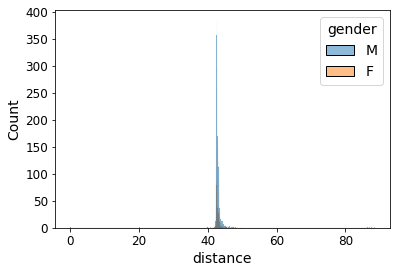

In [749]:
## lets select the biggest major and relevant athletes -> 2019 Berlin marathon
## we discard Boston as this event is only for qualified participants 
## lets see if we have entries for the actual Berlin marathon
## marathon_city='BERLIN 2019'
## marathon_date='30.09.2019'
## we check the right date first 
## what was the distances for this day?

print('Distribution of distance for the day of the Berlin marathon in our db:')

event_db = data[(data['datetime']=='29.09.2019')&(data['major']=='BERLIN 2019')].copy()
sns.histplot(x='distance',hue='gender',data=event_db)
plt.show()

## so everything is clustered around 42 km, but we need to narrow the selection

In [750]:
bm_num=event_db['athlete'].nunique()
print('The db countains results of Berlin marathon for {} athletes.'.format(bm_num))

high_km_limit = 45
low_km_limit = 42

## ... and 21 peoples did not finished :( 
## or their tracker battery did not make it
bm_dsq = event_db[(event_db['distance']<low_km_limit)]['athlete'].count()
print('We exlude {} people due to low mileage.'.format(bm_dsq))
bm_err = event_db[(event_db['distance']>high_km_limit)]['athlete'].count()
print('We also exlude {} people due to unexpectedly high mileage.'.format(bm_err))

# this variable is a dataframe with the results of Berlin marathon
event_db = event_db[(event_db['distance']>low_km_limit)&
                      (event_db['distance']<high_km_limit)]

bm_num_42=event_db['athlete'].nunique()
print('{} athletes have running distance of more than {} km and less than {} km.'.format(bm_num_42,low_km_limit,high_km_limit))

The db countains results of Berlin marathon for 3796 athletes.
We exlude 21 people due to low mileage.
We also exlude 101 people due to unexpectedly high mileage.
3674 athletes have running distance of more than 42 km and less than 45 km.


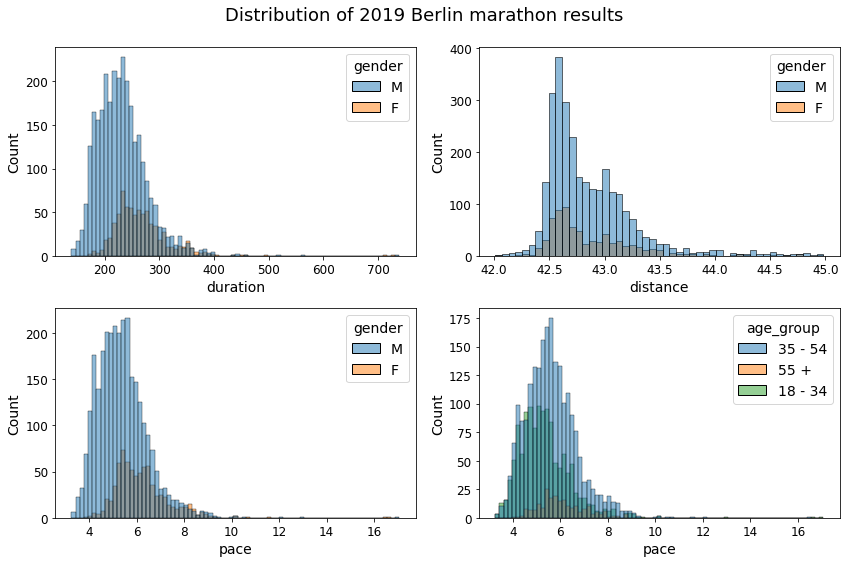

In [751]:
## lets check the duraton and distance distributions (this is still Berlin marathon)
## also i want to see the pace

event_db['pace']=event_db['duration']/event_db['distance']

fig, axs = plt.subplots(2, 2, sharex=False, figsize=(12, 8))

sns.histplot(ax=axs[0,0], x='duration',hue='gender',data=event_db)
sns.histplot(ax=axs[0,1],  x='distance',hue='gender',data=event_db)
sns.histplot(ax=axs[1,0],  x='pace',hue='gender',data=event_db)
sns.histplot(ax=axs[1,1],  x='pace',hue='age_group',data=event_db)

plt.suptitle('Distribution of 2019 Berlin marathon results', fontsize=18)

plt.tight_layout(h_pad=1)
plt.show()

In [752]:
## probaly we need to cut this long tail for pace and set max duration of 7 hours
event_db = event_db[(event_db['duration']<420)&(event_db['pace']<11)]
bm_num_42 = event_db['athlete'].nunique()
print('The number of athletes is reduced to {}.'.format(bm_num_42))

The number of athletes is reduced to 3661.


In [753]:
event_db.describe().round(2)

,distance,duration,pace
count,3661.00,3661.00,3661.00
mean,42.87,237.03,5.53
std,0.43,45.28,1.05
min,42.01,139.00,3.26
25%,42.58,205.00,4.79
50%,42.73,233.00,5.44
75%,43.05,263.00,6.14
max,44.98,404.00,9.45


In [754]:
## lets check the distribution of categoricals

print((event_db['age_group'].value_counts()/len(event_db)*100).round(2))
print((event_db['gender'].value_counts()/len(event_db)*100).round(2))

35 - 54    59.87
18 - 34    34.23
55 +        5.90
Name: age_group, dtype: float64
M    79.65
F    20.35
Name: gender, dtype: float64


## 2019 Berlin marathon training data

In [755]:
## selecting training entries with appropriate major and time interval
## data_berlin=data[(data['datetime']<'29.09.2019')&(data['major'].str.contains('BERLIN 2019'))]
train_db=data[(data['datetime']<'29.09.2019')&(data['major']=='BERLIN 2019')].copy()
bm_train=train_db['datetime'].count()
del data
print('We have info abount {} trainings for the participants of the Berlin marathon.'.format(bm_train))

We have info abount 371661 trainings for the participants of the Berlin marathon.


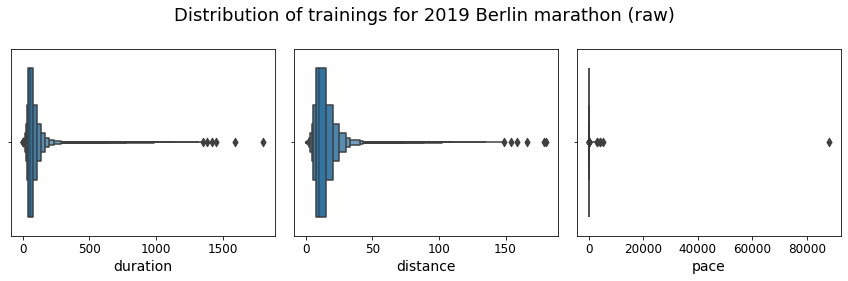

In [756]:
## lets check the distribution of data to see if we have outliers
## also we need to add pace

train_db['pace']=train_db['duration']/train_db['distance']

fig, axs = plt.subplots(1, 3, sharex=False, figsize=(12, 4))

sns.boxenplot(ax=axs[0], x='duration', data=train_db)
sns.boxenplot(ax=axs[1], x='distance', data=train_db)
sns.boxenplot(ax=axs[2], x='pace', data=train_db)

plt.suptitle('Distribution of trainings for 2019 Berlin marathon (raw)', fontsize=18)

plt.tight_layout(h_pad=1)
plt.show()

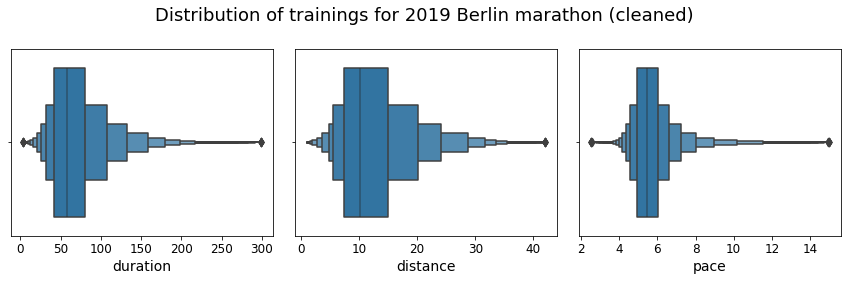

,datetime,athlete,distance,duration,gender,age_group,country,major,pace
65,2019-01-01,69,2.34,13.266667,M,18 - 34,Russia,BERLIN 2019,5.669516
73,2019-01-01,77,10.01,55.433333,M,35 - 54,Taiwan,BERLIN 2019,5.537796
125,2019-01-01,134,12.97,89.000000,M,35 - 54,Poland,BERLIN 2019,6.861989
172,2019-01-01,182,8.00,39.150000,M,18 - 34,Russia,BERLIN 2019,4.893750
243,2019-01-01,257,8.00,43.450000,M,35 - 54,France,BERLIN 2019,5.431250
...,...,...,...,...,...,...,...,...,...
9867417,2019-09-28,37349,11.01,57.216667,M,35 - 54,Russia,BERLIN 2019,5.196791
9867446,2019-09-28,37379,7.88,73.600000,M,35 - 54,Ukraine,BERLIN 2019,9.340102
9867551,2019-09-28,37494,4.85,24.616667,F,35 - 54,United Kingdom,BERLIN 2019,5.075601
9867568,2019-09-28,37513,4.19,34.266667,M,35 - 54,United Kingdom,BERLIN 2019,8.178202


In [757]:
## we are removing:
## - training distances less then 1 km and above 42 km 
## - pace faster then 2.5 min/km and slower then 15 min/km
## - duration less then 1 min and longer then 5 hours
train_db = train_db[(train_db['distance']>1)&
                   (train_db['distance']<42)&
                   (train_db['pace']>2.5)&
                   (train_db['pace']<15)&
                   (train_db['duration']>1)&
                   (train_db['duration']<300)]


train_db['pace']=train_db['duration']/train_db['distance']

fig, axs = plt.subplots(1, 3, sharex=False, figsize=(12, 4))

sns.boxenplot(ax=axs[0], x='duration', data=train_db)
sns.boxenplot(ax=axs[1], x='distance', data=train_db)
sns.boxenplot(ax=axs[2], x='pace', data=train_db)

plt.suptitle('Distribution of trainings for 2019 Berlin marathon (cleaned)', fontsize=18)

plt.tight_layout(h_pad=1)
plt.show()
train_db

In [758]:
## now lets collect training data for every marathoner in our list

dummy_db = train_db[["athlete","distance","duration"]].groupby("athlete").agg(
    {'athlete':'count','distance':sum,'duration':sum})
dummy_db.columns = ['tr_num', 'tr_dist_tot', 'tr_dur_tot']

marathon=event_db.merge(dummy_db, on='athlete', how = 'inner')
marathon['tr_num']=marathon['tr_num'].astype('Int64')
marathon['tr_dist_tot']=marathon['tr_dist_tot'].round(1)
marathon['tr_dur_tot']=marathon['tr_dur_tot'].round(1)

marathon.head()

,datetime,athlete,distance,duration,gender,age_group,country,major,pace,tr_num,tr_dist_tot,tr_dur_tot
0,2019-09-29,14,42.98,163.0,M,35 - 54,Spain,BERLIN 2019,3.792462,203,2368.4,11237.6
1,2019-09-29,30,43.25,232.0,M,55 +,Netherlands,BERLIN 2019,5.364162,51,910.9,5636.0
2,2019-09-29,40,43.64,299.0,F,35 - 54,Netherlands,BERLIN 2019,6.851512,15,155.3,1048.1
3,2019-09-29,69,42.81,267.0,M,18 - 34,Russia,BERLIN 2019,6.236861,111,1086.6,6476.5
4,2019-09-29,77,42.69,282.0,M,35 - 54,Taiwan,BERLIN 2019,6.605762,122,1241.2,7422.8


In [759]:
marathon['tr_pace_avg']=marathon['tr_dur_tot']/marathon['tr_dist_tot'].round(1)
marathon['tr_dist_avg']=marathon['tr_dist_tot']/marathon['tr_num'].round(1)

In [760]:
marathon.describe().round(1)

,distance,duration,pace,tr_num,tr_dist_tot,tr_dur_tot,tr_pace_avg,tr_dist_avg
count,3650.0,3650.0,3650.0,3650.0,3650.0,3650.0,3650.0,3650.0
mean,42.9,236.9,5.5,96.3,1150.0,6341.5,5.7,11.7
std,0.4,45.3,1.0,50.9,729.2,3666.1,0.8,2.5
min,42.0,139.0,3.3,1.0,3.0,16.8,3.6,3.0
25%,42.6,205.0,4.8,59.0,632.8,3713.0,5.1,10.1
50%,42.7,233.0,5.4,93.0,1033.2,5905.2,5.6,11.6
75%,43.0,263.0,6.1,127.0,1482.4,8277.4,6.1,13.2
max,45.0,404.0,9.5,269.0,5276.6,26178.8,10.4,27.8


In [761]:
## more data cleaning

marathon=marathon[marathon['tr_num']>10]
marathon=marathon[marathon['tr_pace_avg']<10]
marathon=marathon[marathon['tr_dist_avg']<30]
marathon.describe().round(1)

,distance,duration,pace,tr_num,tr_dist_tot,tr_dur_tot,tr_pace_avg,tr_dist_avg
count,3559.0,3559.0,3559.0,3559.0,3559.0,3559.0,3559.0,3559.0
mean,42.9,236.4,5.5,98.7,1177.8,6494.2,5.7,11.7
std,0.4,45.1,1.0,49.4,717.1,3584.3,0.8,2.4
min,42.0,139.0,3.3,11.0,56.9,442.8,3.6,3.9
25%,42.6,204.0,4.8,62.0,669.6,3892.4,5.1,10.1
50%,42.7,232.0,5.4,94.0,1047.6,6009.1,5.6,11.6
75%,43.0,262.0,6.1,128.0,1503.4,8354.7,6.1,13.2
max,45.0,404.0,9.5,269.0,5276.6,26178.8,10.0,22.4


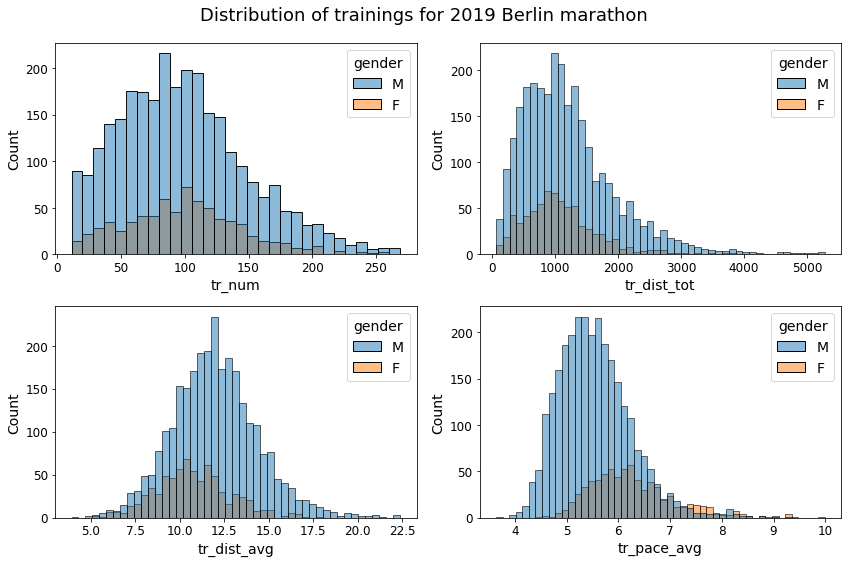

In [762]:
fig, axs = plt.subplots(2, 2, sharex=False, figsize=(12, 8))

sns.histplot(ax=axs[0,0], x='tr_num',hue='gender',data=marathon)
sns.histplot(ax=axs[0,1], x='tr_dist_tot',hue='gender',data=marathon)
sns.histplot(ax=axs[1,0], x='tr_dist_avg',hue='gender',data=marathon)
sns.histplot(ax=axs[1,1], x='tr_pace_avg',hue='gender',data=marathon)

plt.suptitle('Distribution of trainings for 2019 Berlin marathon', fontsize=18)

plt.tight_layout(h_pad=1)
plt.show()


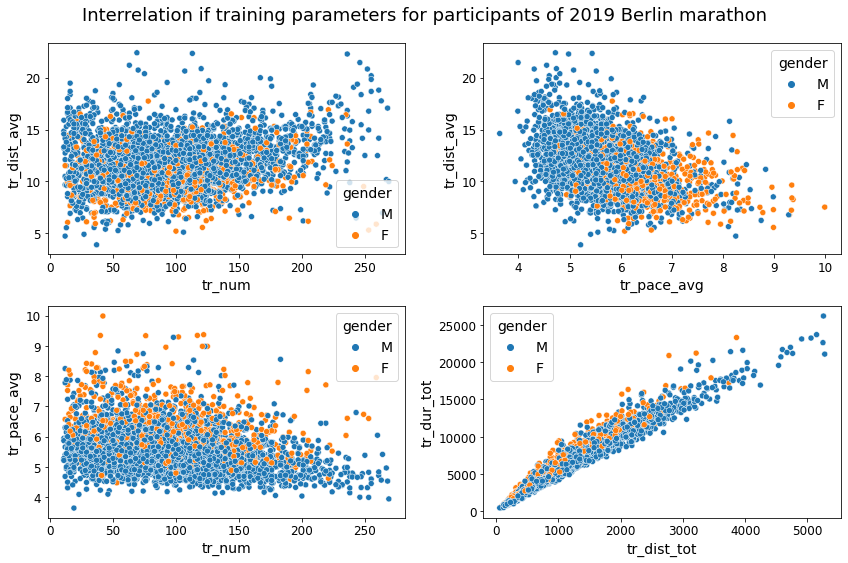

In [863]:
fig, axs = plt.subplots(2, 2, sharex=False, figsize=(12, 8))

sns.scatterplot(ax=axs[0,0], y='tr_dist_avg',x='tr_num',hue='gender',data=marathon)
sns.scatterplot(ax=axs[0,1], y='tr_dist_avg',x='tr_pace_avg',hue='gender',data=marathon)
sns.scatterplot(ax=axs[1,0], y='tr_pace_avg',x='tr_num',hue='gender',data=marathon)
sns.scatterplot(ax=axs[1,1], x='tr_dist_tot',y='tr_dur_tot',hue='gender',data=marathon)

plt.suptitle('Interrelation if training parameters for participants of 2019 Berlin marathon', fontsize=18)

plt.tight_layout(h_pad=1)
plt.show()

+training amount by weeks prior to marathon
+training speed by weeks prior to marathon
+fastest training vs average speed
+chart - pace by weeks vs marathon (last)

list of athlets that are in the selection

- data cleaning (distances too short, paces too high, nymber of training too low)
- marathon results regression from training intencity (gender as categoricals)
- slit sub 3 hours, 3.30, 4.00 and the rest
- normalize pace against marathon pace


## Training analysis

In [967]:
## lets see how the training is happening during the year
grouper = pd.Grouper(axis=1, key='datetime', freq='m', sort=True)
x = train_db[['athlete', 'datetime', 'distance','duration']].groupby(['athlete', grouper],
                                                observed=False, dropna=False).sum()
y = train_db[['athlete', 'datetime', 'distance']].groupby(['athlete', grouper],
                                                observed=False, dropna=False).count()
x['tr_num'] = y['distance']
x = x.unstack(level=1).round(2)
x

distance                                                         \
datetime 2019-01-31 2019-02-28 2019-03-31 2019-04-30 2019-05-31 2019-06-30   
athlete                                                                      
14           277.30     282.61     285.06     160.18     245.91     239.43   
30           142.09     113.25      25.93     107.08     127.58      90.97   
40            51.30        NaN        NaN        NaN        NaN      57.97   
69            44.51      63.90     101.18      57.75     107.44     197.70   
77           138.36     117.47      82.30      87.08     142.50     143.64   
...             ...        ...        ...        ...        ...        ...   
37472         34.54      10.74        NaN       9.99      28.61     101.74   
37494        243.58     283.30     225.44     221.01     269.20     187.98   
37513           NaN        NaN        NaN       6.95        NaN        NaN   
37516        135.18     135.86     116.91     171.12     118.07     133.46   
37552        382.25     456.16     421.92     409.79     320.07     534.44   

                                            duration  ...             \
datetime 2019-07-31 2019-08-31 2019-09-30 2019-01-31  ... 2019-09-30   
athlete                                               ...              
14           315.81     332.59     229.51    1258.48  ...    1032.57   
30            79.27     125.42      99.33     895.72  ...     597.98   
40              NaN      46.01        NaN     347.60  ...        NaN   
69           182.76     251.30      80.03     277.23  ...     440.23   
77           181.15     183.77     164.95     850.07  ...     998.35   
...             ...        ...        ...        ...  ...        ...   
37472        156.23     166.00     140.80     214.13  ...     848.65   
37494        226.36     263.37     204.73    1504.02  ...    1265.22   
37513          4.40      99.13     120.82        NaN  ...     654.57   
37516         81.69     242.62     207.19     721.40  ...    1050.68   
37552        363.42     238.78     197.83    1824.73  ...     833.28   

             tr_num                                                         \
datetime 2019-01-31 2019-02-28 2019-03-31 2019-04-30 2019-05-31 2019-06-30   
athlete                                                                      
14             22.0       21.0       22.0       20.0       27.0       23.0   
30              8.0        5.0        2.0        6.0        9.0        4.0   
40              9.0        NaN        NaN        NaN        NaN        4.0   
69              6.0        8.0       12.0        8.0       11.0       19.0   
77             14.0       12.0        9.0        8.0       15.0       14.0   
...             ...        ...        ...        ...        ...        ...   
37472           8.0        2.0        NaN        1.0        7.0       13.0   
37494          22.0       22.0       22.0       20.0       23.0       26.0   
37513           NaN        NaN        NaN        1.0        NaN        NaN   
37516          15.0       15.0       13.0       16.0       13.0       14.0   
37552          27.0       27.0       28.0       30.0       21.0       30.0   

                                           
datetime 2019-07-31 2019-08-31 2019-09-30  
athlete                                    
14             24.0       26.0       18.0  
30              5.0        5.0        7.0  
40              NaN        2.0        NaN  
69             18.0       21.0        8.0  
77             16.0       16.0       18.0  
...             ...        ...        ...  
37472          16.0       17.0       12.0  
37494          21.0       23.0       22.0  
37513           1.0        9.0        9.0  
37516           9.0       18.0       14.0  
37552          26.0       14.0       12.0  

[3788 rows x 27 columns]

In [968]:
## and we need to add pace as well

cols = x.columns
period_lst = cols.get_level_values("datetime")

for i in period_lst:
    x['pace',i]=x['duration',i]/x['distance',i]
print(x.shape)
x['pace'].min()

(3788, 36)


datetime
2019-01-31    3.223335
2019-02-28    3.688424
2019-03-31    3.798288
2019-04-30    3.406146
2019-05-31    3.368726
2019-06-30    3.438729
2019-07-31    3.306977
2019-08-31    3.389432
2019-09-30    3.503016
Freq: M, dtype: float64

In [969]:
x=x[x.index.isin(marathon['athlete'])==True]
x.shape

(3559, 36)

In [970]:
x.describe().round(2)

distance                                                         \
datetime 2019-01-31 2019-02-28 2019-03-31 2019-04-30 2019-05-31 2019-06-30   
count       2870.00    2952.00    3065.00    3142.00    3227.00    3328.00   
mean         127.79     122.47     138.23     119.58     126.00     137.06   
std           97.88      91.01     100.52      83.42      86.24      88.59   
min            1.01       1.75       1.98       1.02       1.04       1.17   
25%           56.06      54.84      63.20      60.44      64.22      72.39   
50%          104.94     102.57     118.71     104.24     110.33     122.68   
75%          175.48     167.76     191.05     159.20     168.42     181.80   
max          785.60     675.05     662.52     626.96     709.18     594.85   

                                            duration  ...     tr_num  \
datetime 2019-07-31 2019-08-31 2019-09-30 2019-01-31  ... 2019-09-30   
count       3420.00    3517.00    3538.00    2870.00  ...    3538.00   
mean         164.94     194.72     156.18     703.85  ...      12.27   
std          100.86     106.84      78.77     500.07  ...       5.36   
min            1.11       2.05       3.66       5.52  ...       1.00   
25%           93.60     121.99     102.39     330.10  ...       9.00   
50%          150.70     183.20     146.98     608.90  ...      12.00   
75%          217.85     248.52     199.58     968.96  ...      16.00   
max          723.45     762.89     525.25    3976.03  ...      28.00   

               pace                                                         \
datetime 2019-01-31 2019-02-28 2019-03-31 2019-04-30 2019-05-31 2019-06-30   
count       2870.00    2952.00    3065.00    3142.00    3227.00    3328.00   
mean           5.74       5.70       5.68       5.69       5.68       5.74   
std            0.92       0.90       0.90       0.91       0.90       0.89   
min            3.22       3.69       3.80       3.41       3.37       3.44   
25%            5.12       5.07       5.08       5.09       5.07       5.14   
50%            5.60       5.58       5.56       5.57       5.55       5.62   
75%            6.17       6.12       6.11       6.11       6.11       6.19   
max           12.77      14.54      14.02      12.20      12.16      12.21   

                                           
datetime 2019-07-31 2019-08-31 2019-09-30  
count       3420.00    3517.00    3538.00  
mean           5.74       5.70       5.64  
std            0.89       0.87       0.83  
min            3.31       3.39       3.50  
25%            5.13       5.11       5.05  
50%            5.60       5.60       5.53  
75%            6.17       6.14       6.07  
max           12.43      12.12      10.08  

[8 rows x 36 columns]

In [971]:
#count number by period
z = pd.DataFrame(columns=['period', 'n_athlete'])          
z['period'] = x['distance'].columns
#for i in x.
z['n_athlete']=x['distance'].count().tolist()
z['duration']=x['duration'].sum().tolist()/z['n_athlete']
z['distance']=x['distance'].sum().tolist()/z['n_athlete']
z['pace']=z['duration']/z['distance']
z['tr_num']=x['tr_num'].mean().tolist()
z.round(2)

,period,n_athlete,duration,distance,pace,tr_num
0,2019-01-31,2870,703.85,127.79,5.51,11.51
1,2019-02-28,2952,670.21,122.47,5.47,10.47
2,2019-03-31,3065,755.50,138.23,5.47,11.56
3,2019-04-30,3142,658.55,119.58,5.51,10.80
4,2019-05-31,3227,695.59,126.00,5.52,11.53
5,2019-06-30,3328,766.01,137.06,5.59,12.14
6,2019-07-31,3420,916.94,164.94,5.56,13.56
7,2019-08-31,3517,1074.88,194.72,5.52,14.32
8,2019-09-30,3538,853.37,156.18,5.46,12.27


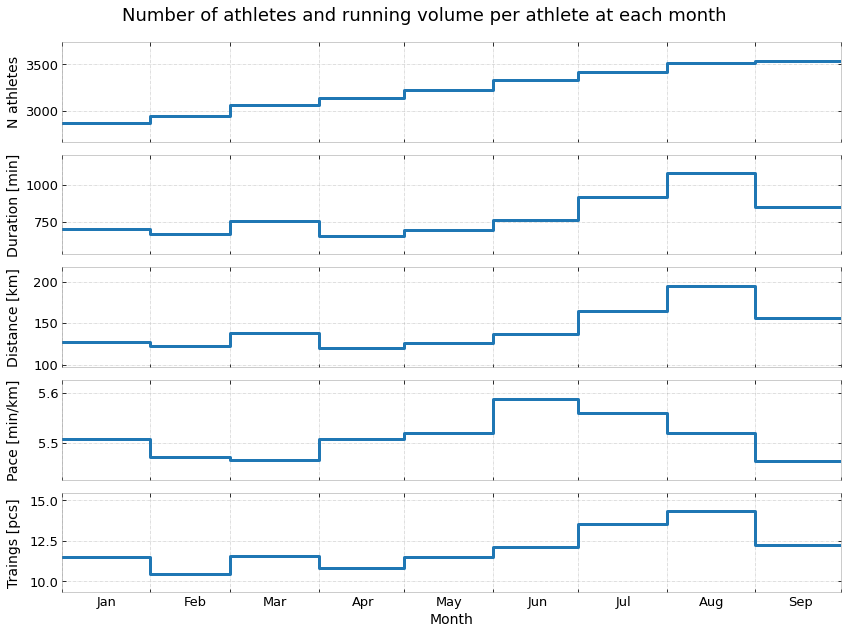

In [972]:
plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

days = [31, 28, 31,30,31,30,31,31,30]
days_c = []
a=0
for i in days:
    a=a+i
    days_c.append(a)

    
import matplotlib.colors

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(12, 9))
cols = z.columns
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','']
y_labels = ['N athletes','Duration [min]','Distance [km]','Pace [min/km]','Traings [pcs]']

for a, ax in enumerate(axs):
    ax.plot(np.append([0],z['period'].dt.dayofyear), 
            np.append(z[cols[a+1]],z[cols[a+1]][len(z[cols[a+1]])-1]), lw=3, drawstyle='steps-post')
    ax.margins(x=0, y=0.3)
    ax.tick_params(direction='in', axis='both', which='major', labelsize=13, top=True, right=True)
    ax.grid(b=True, which='major', color='gray', alpha=0.5, linestyle='-.', linewidth=0.5)
    ax.set_ylabel(y_labels[a])
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_alpha(0.5)
        #spine.linewidth(0.5)

axs[4].set_xlabel('Month')
axs[4].set_xticks(np.append([0],days_c))
axs[4].set_xticklabels(month, rotation=0, ha='center')
offset = matplotlib.transforms.ScaledTranslation(45/72, 0, fig.dpi_scale_trans)
for label in axs[4].get_xticklabels():
    label.set_transform(label.get_transform() + offset)

plt.suptitle('Number of athletes and running volume per athlete at each month', fontsize=18)
fig.align_ylabels(axs)
plt.tight_layout(h_pad=.5)
plt.show()

#z['period'].dt.dayofyear

## Regression analysis 1

In [983]:
reg1_col = ['athlete','gender', 'age_group','tr_dist_m', 
            'tr_dist_tot', 'tr_dist_avg', 'tr_m', 
            'tr_per_m', 'tr_num','tr_pace', 'marathon_pace']
reg1_db = pd.DataFrame(columns=reg1_col)

reg1_db['athlete'] = marathon['athlete']
reg1_db['marathon_pace'] = marathon['pace'].round(2)

reg1_db['gender'] = marathon['gender']
reg1_db['age_group'] = marathon['age_group']
reg1_db['tr_dist_m'] = list(x['distance'].apply(lambda row : row.mean(), axis=1).round(1))
reg1_db['tr_dist_tot'] = marathon['tr_dist_tot']
reg1_db['tr_num'] = marathon['tr_num']
reg1_db['tr_m'] = list(x['distance'].apply(lambda row : 9 - row.isna().sum(), axis=1).round(0))
reg1_db['tr_per_m'] = (marathon['tr_num']/reg1_db['tr_m']).round(1)
reg1_db['tr_pace'] = list(x['pace'].apply(lambda row : row.mean(), axis=1).round(2))
reg1_db['tr_dist_avg'] = marathon['tr_dist_avg'].round(1)
reg1_db['tr_dur_avg'] = (marathon['tr_dur_tot']/reg1_db['tr_num']).round(1)

reg1_db.set_index('athlete',drop=True,inplace=True)

In [984]:
reg1_db.head()

,gender,age_group,tr_dist_m,tr_dist_tot,tr_dist_avg,tr_m,tr_per_m,tr_num,tr_pace,marathon_pace,tr_dur_avg
athlete,,,,,,,,,,,
14,M,35 - 54,263.2,2368.4,11.7,9,22.6,203,4.76,3.79,55.4
30,M,55 +,101.2,910.9,17.9,9,5.7,51,6.20,5.36,110.5
40,F,35 - 54,51.8,155.3,10.4,3,5.0,15,6.75,6.85,69.9
69,M,18 - 34,120.7,1086.6,9.8,9,12.3,111,6.04,6.24,58.3
77,M,35 - 54,137.9,1241.2,10.2,9,13.6,122,6.09,6.61,60.8


In [985]:
reg1_db.corr().round(2)

,tr_dist_m,tr_dist_tot,tr_dist_avg,tr_m,tr_per_m,tr_num,tr_pace,marathon_pace,tr_dur_avg
tr_dist_m,1.00,0.93,0.57,0.10,0.91,0.81,-0.39,-0.54,0.30
tr_dist_tot,0.93,1.00,0.49,0.43,0.86,0.92,-0.37,-0.50,0.23
tr_dist_avg,0.57,0.49,1.00,-0.09,0.24,0.18,-0.43,-0.52,0.77
tr_m,0.10,0.43,-0.09,1.00,0.15,0.53,-0.04,-0.06,-0.12
tr_per_m,0.91,0.86,0.24,0.15,1.00,0.91,-0.27,-0.42,0.03
tr_num,0.81,0.92,0.18,0.53,0.91,1.00,-0.25,-0.38,-0.01
tr_pace,-0.39,-0.37,-0.43,-0.04,-0.27,-0.25,1.00,0.78,0.22
marathon_pace,-0.54,-0.50,-0.52,-0.06,-0.42,-0.38,0.78,1.00,-0.01
tr_dur_avg,0.30,0.23,0.77,-0.12,0.03,-0.01,0.22,-0.01,1.00


In [986]:
reg1_db_cat=reg1_db[['gender','age_group']]
reg1_db_num=reg1_db._get_numeric_data()

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first') 
encoder.fit(reg1_db_cat)
reg1_db_cat_encoded = encoder.transform(reg1_db_cat).toarray() 
cols = encoder.get_feature_names_out(input_features=reg1_db_cat.columns)
reg1_db_cat_encoded = pd.DataFrame(reg1_db_cat_encoded, columns=cols)

reg1_db_cat_encoded.set_index(reg1_db.index,drop=True,inplace=True)
reg1_db_cat_encoded

,gender_M,age_group_35 - 54,age_group_55 +
athlete,,,
14,1.0,1.0,0.0
30,1.0,0.0,1.0
40,0.0,1.0,0.0
69,1.0,0.0,0.0
77,1.0,1.0,0.0
...,...,...,...
37467,1.0,1.0,0.0
37472,1.0,1.0,0.0
37494,0.0,1.0,0.0


In [987]:
from scipy.stats import skew
reg1_db_num.head()
for i in reg1_db_num.columns.tolist():
    print(skew(reg1_db_num[i]),i)

1.4416282028613732 tr_dist_m
1.4018315976492495 tr_dist_tot
0.38159706739127275 tr_dist_avg
-2.255039102353562 tr_m
0.6450565857364091 tr_per_m
0.569351450378118 tr_num
0.981137504991654 tr_pace
0.6930901337484839 marathon_pace
0.47411573425998554 tr_dur_avg


In [1281]:
reg1_db_enc = pd.concat([reg1_db_cat_encoded, reg1_db_num], axis=1)
reg1_db_enc.columns
reg1_db_enc['tr_dist_avg_proc']=(np.log(reg1_db_enc['tr_dist_avg']))

12.068550209461511
[-2.68]
0.28542756263903657
0.26741473395069404


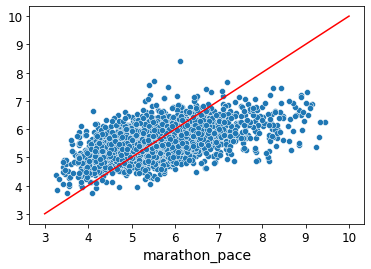

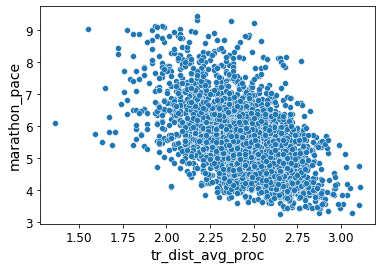

In [1282]:
y = reg1_db_enc['marathon_pace']
X = reg1_db_enc[['tr_dist_avg_proc']]
#X = reg1_db_enc.drop(['finish_time'], axis=1) ### we need to drop some multic columns

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

LR = linear_model.LinearRegression().fit(X_train,y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)
print(LR.intercept_)
print(LR.coef_.round(2))
print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

sns.scatterplot(x=y_train,y=y_train_pred)
X_plot = np.linspace(3, 10, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='r')
plt.show()

sns.scatterplot(x=reg1_db_enc['tr_dist_avg_proc'],y=reg1_db_enc['marathon_pace'])

plt.show()

In [1263]:
def super_regression(cols):
    y = reg1_db_enc['marathon_pace']
    if len(cols)==1:
        X = reg1_db_enc[cols].values.reshape(-1,1)
    else: X = reg1_db_enc[cols]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    LR = linear_model.LinearRegression().fit(X_train,y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    
    return print(r2_score(y_train,y_train_pred).round(3),'for',cols)

regressors = [
    ['gender_M','tr_dist_avg','age_group_35 - 54', 'age_group_55 +'],
    ['gender_M','tr_dist_avg'],
    ['gender_M','tr_m'],
    ['gender_M','tr_per_m'],    
    ['gender_M','tr_dist_tot'],
    ['gender_M','tr_dist_tot','tr_dist_avg'],
    ['gender_M','tr_per_m','tr_dist_avg','tr_m'],
    ['gender_M','tr_per_m','tr_dist_avg','tr_m','age_group_35 - 54', 'age_group_55 +'],
    ['gender_M','tr_per_m'],
    ['gender_M','tr_per_m','tr_m'],
    ['gender_M','tr_per_m','tr_dist_avg'],
    ['tr_pace'],
    ['tr_pace','tr_dur_avg'],
    ['tr_pace','tr_dist_m'],
    ['tr_pace','tr_dist_avg'],
    ['tr_pace','gender_M'],
    ['tr_pace','tr_per_m'],
    ['tr_pace','tr_per_m','tr_dist_avg'],    
    ['tr_pace','tr_per_m','tr_dist_avg','tr_num'],    
    ['tr_pace','tr_num','tr_dist_avg'], 
    ['tr_pace','tr_per_m','tr_dist_avg','tr_dist_tot','tr_m','age_group_35 - 54', 'age_group_55 +'],

]

for i in regressors:
    super_regression(i)

0.352 for ['gender_M', 'tr_dist_avg', 'age_group_35 - 54', 'age_group_55 +']
0.316 for ['gender_M', 'tr_dist_avg']
0.105 for ['gender_M', 'tr_m']
0.283 for ['gender_M', 'tr_per_m']
0.327 for ['gender_M', 'tr_dist_tot']
0.396 for ['gender_M', 'tr_dist_tot', 'tr_dist_avg']
0.419 for ['gender_M', 'tr_per_m', 'tr_dist_avg', 'tr_m']
0.46 for ['gender_M', 'tr_per_m', 'tr_dist_avg', 'tr_m', 'age_group_35 - 54', 'age_group_55 +']
0.283 for ['gender_M', 'tr_per_m']
0.283 for ['gender_M', 'tr_per_m', 'tr_m']
0.418 for ['gender_M', 'tr_per_m', 'tr_dist_avg']
0.604 for ['tr_pace']
0.639 for ['tr_pace', 'tr_dur_avg']
0.67 for ['tr_pace', 'tr_dist_m']
0.647 for ['tr_pace', 'tr_dist_avg']
0.605 for ['tr_pace', 'gender_M']
0.654 for ['tr_pace', 'tr_per_m']
0.684 for ['tr_pace', 'tr_per_m', 'tr_dist_avg']
0.684 for ['tr_pace', 'tr_per_m', 'tr_dist_avg', 'tr_num']
0.678 for ['tr_pace', 'tr_num', 'tr_dist_avg']
0.687 for ['tr_pace', 'tr_per_m', 'tr_dist_avg', 'tr_dist_tot', 'tr_m', 'age_group_35 - 54', '

## Regression analysis 2

In [981]:

def distance_type(x):
    if x<6: return '5km'
    elif x<11: return '10km'
    elif x<16: return '15km'
    elif x<22: return '21km'
    else: return 'long'
train_db['dist_type']=train_db['distance'].apply(distance_type)

(train_db['dist_type'].value_counts()/train_db.shape[0]*100).round(2)


10km    40.15
15km    23.65
5km     14.58
21km    13.09
long     8.52
Name: dist_type, dtype: float64

In [1039]:
bin_db_pace=train_db[['athlete','dist_type','pace']].groupby(['athlete','dist_type']).mean().unstack(level=1).round(2)
bin_db_pace.columns = bin_db_pace.columns.droplevel()
bin_db_pace=bin_db_pace[['5km','10km','15km','21km','long']]
bin_db_pace.head()

dist_type,5km,10km,15km,21km,long
athlete,,,,,
14,5.66,5.21,4.67,4.23,4.57
30,6.50,6.55,6.19,6.13,6.04
40,6.83,6.71,6.85,6.73,6.72
69,6.31,6.05,5.98,5.63,5.70
77,7.82,6.17,4.78,7.63,NaN


In [1099]:
bins_db_dist=train_db[['athlete','dist_type','distance']].groupby(['athlete','dist_type']).sum().unstack(level=1).round(2)
bins_db_dist.columns = bins_db_dist.columns.droplevel()
bins_db_dist=bins_db_dist[['5km','10km','15km','21km','long']].fillna(0)
bins_db_dist.head()

dist_type,5km,10km,15km,21km,long
athlete,,,,,
14,84.39,777.73,664.62,527.67,313.99
30,3.68,199.71,82.49,111.14,513.90
40,25.37,31.09,13.87,59.95,25.00
69,73.32,558.39,240.14,139.52,75.20
77,21.89,957.82,218.85,42.66,0.00


In [1178]:
bin_db = bin_db_pace.merge(bins_db_dist, on='athlete', how = 'inner',suffixes=('_pace', '_count')).copy()
bin_db = bin_db.merge(marathon[['athlete','tr_num','pace','tr_pace_avg','tr_dist_tot','gender']], on='athlete', how = 'inner').copy()


bin_db = bin_db[bin_db['long_pace'].isna()==False]

bin_db['5km_count']  = ( bin_db['5km_count'].fillna(0)   ).round(2)
bin_db['10km_count'] = ( bin_db['10km_count'].fillna(0)  ).round(2)
bin_db['15km_count'] = ( bin_db['15km_count'].fillna(0)  ).round(2)
bin_db['21km_count'] = ( bin_db['21km_count'].fillna(0)  ).round(2)
bin_db['long_count'] = ( bin_db['long_count'].fillna(0)  ).round(2)

bin_sqd = pd.DataFrame(x['distance'].std(axis=1),columns=['std'])
bin_db = bin_db.merge(bin_sqd, on='athlete', how = 'inner').copy()
bin_db=bin_db[bin_db['std'].isna()==False]


#bin_db = bin_db.merge(x['distance']['2019-09-30'], on='athlete', how = 'inner').copy()
#from datetime import datetime
#bin_db.columns = [i.strftime('%Y-%m-%d') if isinstance(i, datetime) else i for i in bin_db.columns]
#bin_db=bin_db.rename(columns={'2019-09-30':'sep'})
#bin_db['sep']=bin_db['sep'].fillna(0)
#bin_db['sep_to_tot']=bin_db['sep']/bin_db['tr_dist_tot']


#bin_db['spt_aug'] = list(x['distance']['2019-09-30'].fillna(0)/x['distance']['2019-08-31'].fillna(0))
#bin_db['ratio'] = ( (bin_db['long_count']+bin_db['21km_count']+bin_db['15km_count'])/bin_db['tr_dist_tot']  ).round(2)
bin_db['athlete'] = bin_db['athlete'].astype('object')
bin_db['gender'] = list(bin_db['gender'].apply(lambda x: 1 if x=='F' else 0))


bin_db.head()

#sns.pairplot(bin_db)
#bin_db.columns

,athlete,5km_pace,10km_pace,15km_pace,21km_pace,long_pace,5km_count,10km_count,15km_count,21km_count,long_count,tr_num,pace,tr_pace_avg,tr_dist_tot,gender,std
0,14,5.66,5.21,4.67,4.23,4.57,84.39,777.73,664.62,527.67,313.99,203,3.792462,4.744807,2368.4,0,51.536732
1,30,6.50,6.55,6.19,6.13,6.04,3.68,199.71,82.49,111.14,513.90,51,5.364162,6.187287,910.9,0,34.258079
2,40,6.83,6.71,6.85,6.73,6.72,25.37,31.09,13.87,59.95,25.00,15,6.851512,6.748873,155.3,1,5.993255
3,69,6.31,6.05,5.98,5.63,5.70,73.32,558.39,240.14,139.52,75.20,111,6.236861,5.960335,1086.6,0,72.492725
4,102,8.94,7.89,7.60,7.54,7.12,322.16,361.47,205.32,106.15,70.95,136,7.407407,8.012946,1066.0,0,32.701805


In [1176]:
bin_db['std'].isna().sum()

7

In [1181]:
def super_regression(cols):
    db=bin_db#[bin_db['gender']==1]
    y = db['pace']
    if len(cols)==1:
        X = db[cols].values.reshape(-1,1)
    else: X = db[cols]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    LR = linear_model.LinearRegression().fit(X_train,y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    
    return print(r2_score(y_train,y_train_pred).round(3),'for',cols)

regressors = [['15km_count'],
              ['15km_count','5km_count'],
              ['15km_count','long_count','5km_count'],
              ['long_count','long_pace','tr_pace_avg'],
              ['15km_count','long_pace','tr_pace_avg','gender'],
              ['long_pace'],
              ['tr_pace_avg'],
              ['tr_pace_avg','tr_dist_tot'],
              ['tr_dist_tot'],
              ['std','tr_pace_avg'],
  ]

for i in regressors:
    super_regression(i)


0.232 for ['15km_count']
0.259 for ['15km_count', '5km_count']
0.307 for ['15km_count', 'long_count', '5km_count']
0.687 for ['long_count', 'long_pace', 'tr_pace_avg']
0.693 for ['15km_count', 'long_pace', 'tr_pace_avg', 'gender']
0.611 for ['long_pace']
0.636 for ['tr_pace_avg']
0.684 for ['tr_pace_avg', 'tr_dist_tot']
0.24 for ['tr_dist_tot']
0.668 for ['std', 'tr_pace_avg']


In [1078]:
skew(bin_db['15km_count'])

1.4335627258319912

In [992]:
## Regression analysis 3

In [ ]:


def super_regression(cols):
    y = speed_db_dist1['pace']
    if len(cols)==1:
        X = speed_db_dist1[cols].values.reshape(-1,1)
    else: X = speed_db_dist1[cols]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    LR = linear_model.LinearRegression().fit(X_train,y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    
    return print(r2_score(y_train,y_train_pred).round(3),'for',cols)

regressors = [['5km%', '10km%', '15km%', '21km%', 'long%'],
              ['5km', '10km', '15km', '21km', 'long'],
              ['5km%', '10km%', '15km%', '21km%', 'long%','tr_pace_avg'],
              ['tr_num','tr_pace_avg', '5km%', '10km%', '15km%', '21km%', 'long%'],
              ['tr_num','tr_pace_avg', '5km%', '10km%', '15km%', '21km%', 'long%','gender','21km']    
]

for i in regressors:
    super_regression(i)


